# Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd
from pylab import *
from pprint import pprint
from random import uniform as rand
%matplotlib inline

# Import data

Import the given excel file.

In [2]:
data_df = pd.read_excel('./Data_Case II.xlsx', index_col='Date')
data_df = data_df.reindex(sorted(data_df.columns), axis=1)
data_df.head()

,Commodities,Equity,Fixed income,Hedge Funds,Real Estate
Date,,,,,
2004-12-31,0.000000,0.000000,0.000000,0.000000,0.000000
2005-01-07,0.061548,0.014354,0.019900,0.028100,-0.007989
2005-01-14,0.037780,-0.003776,0.003577,-0.003210,-0.007760
2005-01-21,0.007729,-0.007996,0.001278,0.001171,0.009977
2005-01-28,-0.013148,0.006571,0.002871,0.001559,-0.018529


Visualization of the classes:

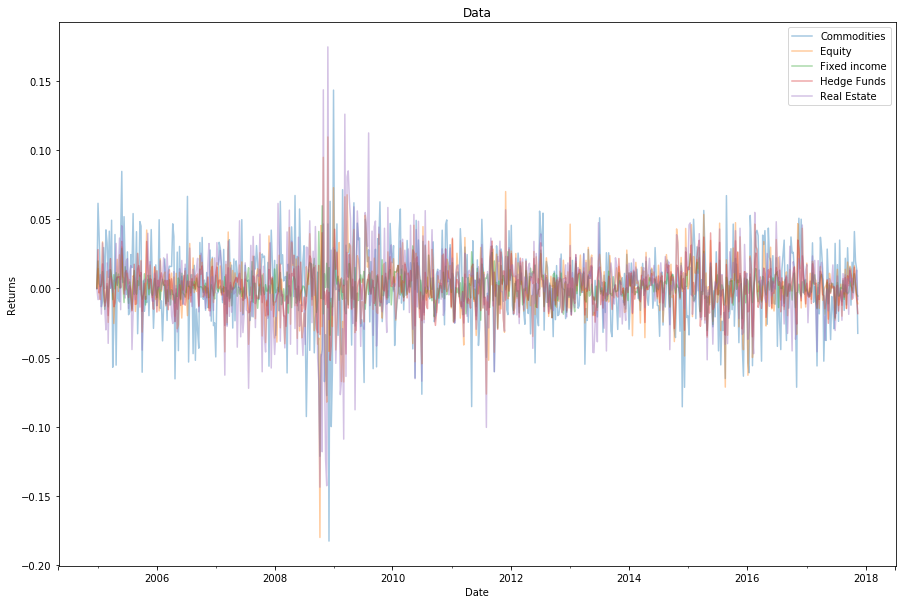

In [3]:
data_df.plot(alpha=.4, figsize = (15,10), title='Data')
plt.ylabel('Returns');

# Historical returns and volatilities

Calculate the means of the returns and the respective volatilities for the 5 classes given.

Firstly, returns:

In [4]:
return_mean = data_df.mean()
annualised_return = return_mean * 52
annualised_return

Commodities     0.057280
Equity          0.093558
Fixed income    0.044531
Hedge Funds     0.023070
Real Estate     0.086696
dtype: float64

Secondly, standard deviations:

In [5]:
return_stdev = data_df.std()
annualised_stdev = return_stdev * np.sqrt(52)
annualised_stdev

Commodities     0.214509
Equity          0.163519
Fixed income    0.070714
Hedge Funds     0.097795
Real Estate     0.207877
dtype: float64

Let us check the relatioships between E(return) and σ:

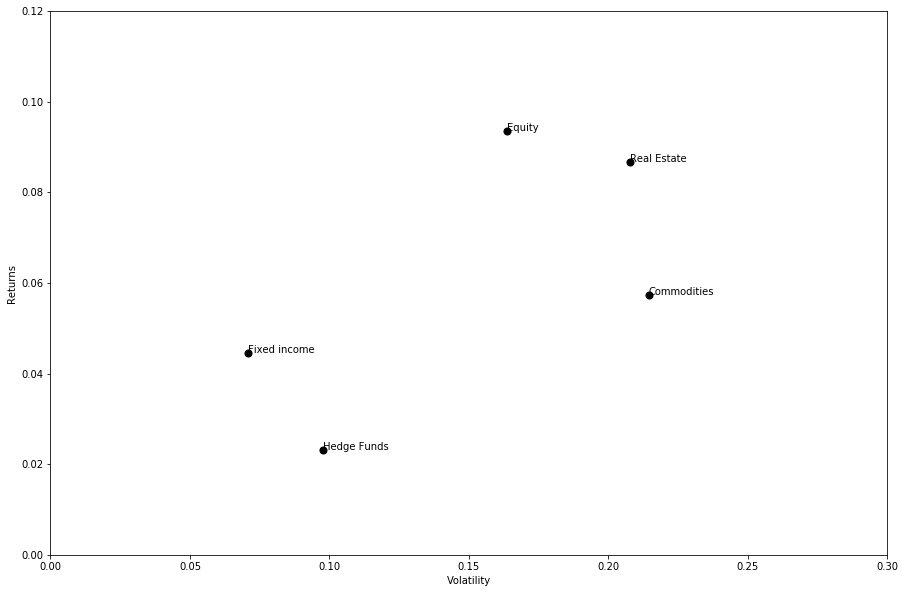

In [6]:
fig, ax = plt.subplots(figsize = (15,10))
ax.scatter(annualised_stdev, annualised_return, marker="o",color='xkcd:black',s=50)
for i, txt in enumerate(data_df.columns.tolist()):
    ax.annotate(txt, (annualised_stdev.tolist()[i],annualised_return.tolist()[i]))
plt.ylim((0.00,0.12))
plt.xlim((0.00,0.3))
plt.xlabel('Volatility')
plt.ylabel('Returns');

# Portfolios

Given that the risk free rate is 3%:

In [7]:
risk_free = .03

Set number of runs of random portfolio weights:

In [8]:
num_portfolios = 100000

Set some variables:

In [9]:
#list of stocks in portfolio
stocks = data_df.columns.tolist()

#specify returns dataframe
returns = data_df
 
#calculate mean daily return and covariance of daily returns
mean_daily_returns = returns.mean()
cov_matrix = returns.cov()
 
#set up array to hold results
#We have increased the size of the array to hold the weight values for each stock
results = np.zeros((4+len(stocks)-1,num_portfolios))

## Calculate Returns, Volatility, SR, and weights for the 5 classes

In [10]:
for i in range(num_portfolios):
    #select random weights for portfolio holdings
    weights = np.array(np.random.random(5))
    
    #rebalance weights to sum to 1
    weights /= np.sum(weights)
    
    #calculate portfolio return and volatility
    portfolio_return = np.sum(mean_daily_returns * weights) * 52
    portfolio_std_dev = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights))) * np.sqrt(52)
 
    #store results in results array
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    
    #store Sharpe Ratio
    results[2,i] = (results[0,i]-risk_free) / results[1,i]
    
    #iterate through the weight vector and add data to results array
    for j in range(len(weights)):
        results[j+3,i] = weights[j]

Convert results array to Pandas DataFrame:

In [11]:
results_frame = pd.DataFrame(results.T,columns=['ret','stdev','sharpe',stocks[0],stocks[1],stocks[2],stocks[3],stocks[4]])
results_frame.head()

,ret,stdev,sharpe,Commodities,Equity,Fixed income,Hedge Funds,Real Estate
0,0.053357,0.095535,0.244487,0.301705,0.009653,0.385386,0.130139,0.173116
1,0.068295,0.117054,0.327161,0.293453,0.326782,0.235100,0.032970,0.111696
2,0.070502,0.125306,0.323226,0.068088,0.273897,0.176271,0.135762,0.345981
3,0.056270,0.103103,0.254794,0.109683,0.111668,0.201015,0.306321,0.271313
4,0.055674,0.101614,0.252658,0.179711,0.019047,0.265234,0.230771,0.305237


Get Sharpe ratio and Minimum Variance Portfolio

In [12]:
#locate position of portfolio with highest Sharpe Ratio
max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
#locate positon of portfolio with minimum standard deviation
min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]

## Sharpe Ratio

In [13]:
print('Sharpe ratio:', min_vol_port[2])

Sharpe ratio: 0.290314888278


Weights:

In [14]:
print(max_sharpe_port[3:])

Commodities     0.005919
Equity          0.487280
Fixed income    0.482973
Hedge Funds     0.006191
Real Estate     0.017636
Name: 97394, dtype: float64


## Minimum Variance Portfolio

In [15]:
print('Standard Deviation of the Minimum Variance Portfolio:', min_vol_port[1])

Standard Deviation of the Minimum Variance Portfolio: 0.0653474547872


Weights:

In [16]:
print(min_vol_port[3:])

Commodities     0.075642
Equity          0.066358
Fixed income    0.798840
Hedge Funds     0.035701
Real Estate     0.023459
Name: 62084, dtype: float64


## Optimal Portfolio

This is how our tangency portfolio looks like:

In [17]:
max_sharpe_port

ret             0.069107
stdev           0.091658
sharpe          0.426664
Commodities     0.005919
Equity          0.487280
Fixed income    0.482973
Hedge Funds     0.006191
Real Estate     0.017636
Name: 97394, dtype: float64

We know that the investor has a Investor quadratic utility function with a risk aversion level ($\gamma$) of 6.
$$ U(r_P) = E(r_P)- \gamma \frac{\sigma_P^2}{2} $$

In [18]:
r_T = max_sharpe_port[0]
sigma_T = max_sharpe_port[1]
r_f = risk_free
gamma = 3

To find optimal portfolio choice:
$$ w_T = \frac{r_T-r_f}{\gamma \sigma_T^2} $$

In [19]:
w_T = (r_T-r_f)/(gamma*(sigma_T**2))

In [20]:
print('Optimal weight on the tangency portfolio:', round(w_T,2))

Optimal weight on the tangency portfolio: 1.55


### Expected return:

In [21]:
E_o = w_T*r_T + (1-w_T)*r_f

In [22]:
print('Expected return:', round(E_o,2))

Expected return: 0.09


### Standard deviation:

In [23]:
sigma_o = w_T*sigma_T

In [24]:
print('Standard Deviation:', round(sigma_o,2))

Standard Deviation: 0.14


Also, his utility:

In [25]:
U_o = E_o - gamma*(sigma_o**2)/2
print('Utility:', round(U_o,2))

Utility: 0.06


# Portfolios graph

In [26]:
def graph_curve(formula, x_range):  
    x = np.array(x_range)  
    y = formula(x)
    plt.plot(x, y)  
    plt.show()  

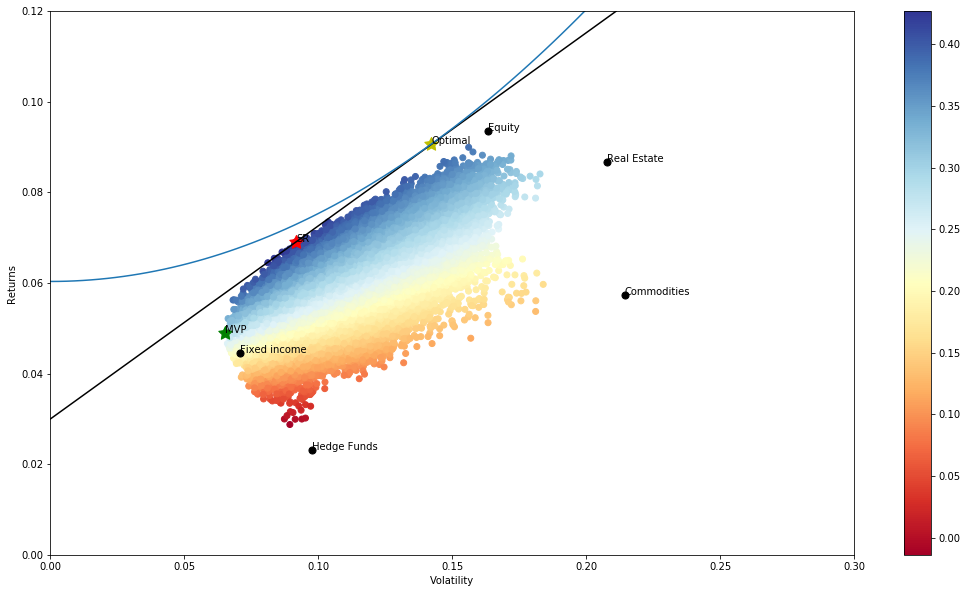

In [27]:
# Set configuration of the graph
plt.figure(figsize=(18, 10))
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.ylim((0.00,0.12))
plt.xlim((0.00,0.3))

# Create scatter plot coloured by Sharpe Ratio
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')    
plt.colorbar()

# Add classes
plt.scatter(annualised_stdev, annualised_return, marker="o",color='xkcd:black',s=50)
for i, txt in enumerate(data_df.columns.tolist()):
    plt.annotate(txt, (annualised_stdev.tolist()[i],annualised_return.tolist()[i]))

# Plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=200)
plt.annotate('SR', (max_sharpe_port[1],max_sharpe_port[0]))

# Plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='g',s=200)
plt.annotate('MVP', (min_vol_port[1],min_vol_port[0]))
             
# Add CML line
x1, y1 = [0,0.211204210651287], [risk_free,.12]
plt.plot(x1, y1, color='k')

# Add optimal portfolio 
plt.scatter(sigma_o,E_o,marker=(5,1,0),color='y',s=200)
plt.annotate('Optimal', (sigma_o,E_o))

# Add investors utility curve
graph_curve(lambda x: (U_o+gamma*(x**2)/2), np.linspace(0.0,0.3, 100));

<br>